# Pokémon battle classifier

This project is mainly to see if classical machine learning models can predict the outcome of a Pokémon 1v1 battle, with only the base stats of each Pokémon. 

The battle data is obtained from <a href='https://pokemonshowdown.com/'>pokemonshowdown</a> and the base stats data of all Pokémon is from <a href='https://pokemondb.net/'>Pokémon db</a> using web srcaping techiques (previous projects), and stored in `.json` format.  

The data will then be pre-processed (such as removing invalid, repeated data, normalising data ...) before passing into modelling. There will also be some features engineering and statatistical analysis after that. 

kNN, Logistic regression and Decision tree are the 3 main learners in this notebook, along with basic hyperparameters optimisation and evaluation to achieve possible best results. ROC and AUC will be the main metrics to decide which model is the best to go for.  

TL;DR: models need more data (on diversity), process is ok but data too bad so that models are bad

In [1]:
# since there might be some random process going on so fix them
seed = 42

# Before applying ML

## Importing and re-formating data

First, we need to import the data we have obtained.  
1. match or battle log data: `{p1 pokemon, p2 pokemon, did p1 win?, URL}`  
2. base stats of each pokemon: `{'Id', 'Name', 'Type(s)', 'TotalBS', 'HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed'}`  

<mark>Q: should pl pokemon be the pokemon which moves first in the match? it is very ambiguous to have pl pokemon just picked by system randomly.</mark>  
A: randonly picked could be better, if p1 always move first then there will be an implicit variable

In [2]:
import json

# 1. match or battle log data
with open('./data/match_ok.json', 'r') as f:
    matches = json.load(f)
# 2. base stats of each pokemon
with open('./data/baseStats.json', 'r') as f:
    baseStats = json.load(f)

# to see how they look like
print(matches[3])
print(baseStats[3])

{'pokemon1': 'arcanine', 'pokemon2': 'sharpedo', 'pokemon1 wins': 1, 'url': 'https://replay.pokemonshowdown.com/destiny-challengecup1v1-550920.log'}
{'Id': 3, 'Name': 'Mega Venusaur', 'Type(s)': ['GRASS', 'POISON'], 'TotalBS': '625', 'HP': '80', 'Attack': '100', 'Defense': '123', 'Special Attack': '122', 'Special Defense': '120', 'Speed': '80'}



Then we need to construct the features and labels from these 2 databases,  
into a format looks like: `{'p1HP' ,'p1ATK' ,'p1DEF' ,'p1SpATK' ,'p1SpDEF' ,'p1SPD' ,'p2HP' ,'p2ATK' ,'p2DEF' ,'p2SpATK' ,'p2SpDEF' ,'p2SPD' ,'p1wins'}`

In [3]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    info = [i for i in baseStats if p1_pokemon == i['Name'].lower() or p2_pokemon == i['Name'].lower()]  # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(info[0]['HP']),
            'p1ATK' : int(info[0]['Attack']),
            'p1DEF' : int(info[0]['Defense']),
            'p1SpATK' : int(info[0]['Special Attack']),
            'p1SpDEF' : int(info[0]['Special Defense']),
            'p1SPD' : int(info[0]['Speed']),
            'p2HP' : int(info[1]['HP']),
            'p2ATK' : int(info[1]['Attack']),
            'p2DEF' : int(info[1]['Defense']),
            'p2SpATK' : int(info[1]['Special Attack']),
            'p2SpDEF' : int(info[1]['Special Defense']),
            'p2SPD' : int(info[1]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8475 rows of data can be proceeded, 
420 rows of data went missing


Seems like the problem of missing data is due to p1_pokemon is the same as p2_pokemon.  
<mark>Q: are repeated pokemons bad data?</mark>  
A: include them

In [4]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    p1_info = [i for i in baseStats if p1_pokemon == i['Name'].lower()] # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    p2_info = [i for i in baseStats if p2_pokemon == i['Name'].lower()]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(p1_info[0]['HP']),
            'p1ATK' : int(p1_info[0]['Attack']),
            'p1DEF' : int(p1_info[0]['Defense']),
            'p1SpATK' : int(p1_info[0]['Special Attack']),
            'p1SpDEF' : int(p1_info[0]['Special Defense']),
            'p1SPD' : int(p1_info[0]['Speed']),
            'p2HP' : int(p2_info[0]['HP']),
            'p2ATK' : int(p2_info[0]['Attack']),
            'p2DEF' : int(p2_info[0]['Defense']),
            'p2SpATK' : int(p2_info[0]['Special Attack']),
            'p2SpDEF' : int(p2_info[0]['Special Defense']),
            'p2SPD' : int(p2_info[0]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8895 rows of data can be proceeded, 
0 rows of data went missing


Convert them into pandas DataFrame for better visualistion and statistics summaries.  

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data)
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
0,100,150,120,120,100,90,50,75,75,65,65,50,1
1,85,73,70,73,115,67,80,80,90,110,130,110,1
2,66,41,77,61,87,23,100,120,100,150,120,90,0
3,90,110,80,100,80,95,70,120,40,95,40,95,1
4,115,140,130,55,55,40,85,50,95,120,115,80,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   p1HP     8895 non-null   int64
 1   p1ATK    8895 non-null   int64
 2   p1DEF    8895 non-null   int64
 3   p1SpATK  8895 non-null   int64
 4   p1SpDEF  8895 non-null   int64
 5   p1SPD    8895 non-null   int64
 6   p2HP     8895 non-null   int64
 7   p2ATK    8895 non-null   int64
 8   p2DEF    8895 non-null   int64
 9   p2SpATK  8895 non-null   int64
 10  p2SpDEF  8895 non-null   int64
 11  p2SPD    8895 non-null   int64
 12  p1wins   8895 non-null   int64
dtypes: int64(13)
memory usage: 903.5 KB


## Feature engineering
- the BaseStats difference between pokemon 1 and pokemon 2
- the BaseStats difference between attack and defence features 

In [7]:
# BaseStats difference between attack and defence features
df['p1ATKp2DEF'] = df['p1ATK'] - df['p2DEF'] # p1 atk to p2 def
df['p2ATKp1DEF'] = df['p2ATK'] - df['p1DEF'] # p2 atk to p1 def
df['p1SpATKp2SpDEF'] = df['p1SpATK'] - df['p2SpDEF'] # p1 spatk to p2 spdef
df['p2SpATKp1SpDEF'] = df['p2SpATK'] - df['p1SpDEF'] # p2 spatk to p1 spdef

# aseStats difference between pokemon 1 and pokemon 2, just speed
df['p1SPDp2SPD'] = df['p1SPD'] - df['p2SPD']

# re-locate 'p1wins'
wins = df['p1wins']
df.drop('p1wins', axis='columns', inplace=True)
df['p1wins'] = wins

df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD,p1wins
0,100,150,120,120,100,90,50,75,75,65,65,50,75,-45,55,-35,40,1
1,85,73,70,73,115,67,80,80,90,110,130,110,-17,10,-57,-5,-43,1
2,66,41,77,61,87,23,100,120,100,150,120,90,-59,43,-59,63,-67,0
3,90,110,80,100,80,95,70,120,40,95,40,95,70,40,60,15,0,1
4,115,140,130,55,55,40,85,50,95,120,115,80,45,-80,-60,65,-40,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            8895 non-null   int64
 1   p1ATK           8895 non-null   int64
 2   p1DEF           8895 non-null   int64
 3   p1SpATK         8895 non-null   int64
 4   p1SpDEF         8895 non-null   int64
 5   p1SPD           8895 non-null   int64
 6   p2HP            8895 non-null   int64
 7   p2ATK           8895 non-null   int64
 8   p2DEF           8895 non-null   int64
 9   p2SpATK         8895 non-null   int64
 10  p2SpDEF         8895 non-null   int64
 11  p2SPD           8895 non-null   int64
 12  p1ATKp2DEF      8895 non-null   int64
 13  p2ATKp1DEF      8895 non-null   int64
 14  p1SpATKp2SpDEF  8895 non-null   int64
 15  p2SpATKp1SpDEF  8895 non-null   int64
 16  p1SPDp2SPD      8895 non-null   int64
 17  p1wins          8895 non-null   int64
dtypes: int64(18)
memory usage: 1

## Data cleaning 
- just drop nan and drop duplicates

In [9]:
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 8893
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            6900 non-null   int64
 1   p1ATK           6900 non-null   int64
 2   p1DEF           6900 non-null   int64
 3   p1SpATK         6900 non-null   int64
 4   p1SpDEF         6900 non-null   int64
 5   p1SPD           6900 non-null   int64
 6   p2HP            6900 non-null   int64
 7   p2ATK           6900 non-null   int64
 8   p2DEF           6900 non-null   int64
 9   p2SpATK         6900 non-null   int64
 10  p2SpDEF         6900 non-null   int64
 11  p2SPD           6900 non-null   int64
 12  p1ATKp2DEF      6900 non-null   int64
 13  p2ATKp1DEF      6900 non-null   int64
 14  p1SpATKp2SpDEF  6900 non-null   int64
 15  p2SpATKp1SpDEF  6900 non-null   int64
 16  p1SPDp2SPD      6900 non-null   int64
 17  p1wins          6900 non-null   int64
dtypes: int64(18)
memory usage: 1

## Train-test-split
1. separate X and y
2. convert to numpy array
3. split

In [10]:
y = df['p1wins'].to_numpy()  # using [[]] is to convert pd.series into pd.DataFrame, so than when converted to numpy it will have the shape of (n, 1) instead of (n, )
X = df.loc[ :, df.columns != 'p1wins' ].to_numpy()

print(f"x shape: {X.shape}\ny shape: {y.shape}")

x shape: (6900, 17)
y shape: (6900,)


In [11]:
from sklearn.model_selection import train_test_split

split_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size, random_state=seed, shuffle=True)

print(f'train set: \nX: {X_train.shape}, y: {y_train.shape}\ntest set: \nX: {X_test.shape}, y: {y_test.shape}\nvalidation set: \nX: {X_val.shape}, y: {y_val.shape}')

train set: 
X: (4416, 17), y: (4416,)
test set: 
X: (1104, 17), y: (1104,)
validation set: 
X: (1380, 17), y: (1380,)


done
___

## Normalisation and Standardisation  

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

done
___

## Statistics explanations 

consider only the training dataset

In [13]:
df_train_scaled = pd.DataFrame(X_train_scaled)
df_train_scaled['y'] = pd.DataFrame(y_train)

df_train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,y
count,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4416.000000
mean,1.448117e-16,1.029772e-16,-1.914732e-16,-1.134358e-16,-2.638791e-16,5.712017e-17,-6.556752e-17,-6.596977e-17,9.654113e-18,-4.344351e-17,6.596977e-17,3.740969e-17,3.218038e-17,-4.827057e-18,6.436076e-18,-3.218038e-18,3.378940e-17,0.501359
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,0.500055
min,-2.813733e+00,-2.911869e+00,-2.816454e+00,-2.555487e+00,-2.618654e+00,-2.648128e+00,-2.768796e+00,-2.869691e+00,-2.785635e+00,-2.538339e+00,-2.603290e+00,-2.617093e+00,-5.580527e+00,-5.459422e+00,-5.781320e+00,-5.846109e+00,-4.328657e+00,0.000000
25%,-5.144469e-01,-6.810822e-01,-5.874139e-01,-8.897554e-01,-6.431554e-01,-6.847433e-01,-5.146108e-01,-7.143360e-01,-5.667126e-01,-8.803588e-01,-6.375484e-01,-6.740730e-01,-5.689624e-01,-6.028857e-01,-6.683832e-01,-6.707018e-01,-6.896545e-01,0.000000
50%,-1.026345e-01,4.064310e-02,-7.302001e-02,1.763125e-01,-5.050584e-02,2.921472e-02,-1.108762e-01,-6.607274e-03,-5.465363e-02,1.807484e-01,-4.782593e-02,3.247966e-02,4.519990e-02,2.221295e-02,3.956184e-02,1.935248e-02,-2.570112e-03,1.000000
75%,4.121310e-01,7.623684e-01,4.413739e-01,7.426611e-01,5.421438e-01,7.431728e-01,3.937921e-01,8.297994e-01,4.574053e-01,7.444616e-01,5.418966e-01,7.390323e-01,6.839287e-01,6.713539e-01,7.212867e-01,6.563257e-01,6.336191e-01,1.000000
max,5.902963e+00,2.861933e+00,4.899454e+00,2.874797e+00,5.678440e+00,4.312963e+00,5.776921e+00,2.792138e+00,4.895249e+00,2.767197e+00,5.652825e+00,4.271796e+00,3.042312e+00,4.061312e+00,2.976223e+00,3.098056e+00,3.560090e+00,1.000000


In [14]:
df_train_scaled.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,y
0,1.000000,0.153319,-0.106631,0.073121,0.212254,-0.040397,0.103823,0.057347,0.045037,0.062080,0.073698,0.045795,0.082402,0.117617,0.008398,-0.092892,-0.061785,-0.005027
1,0.153319,1.000000,0.323387,0.058068,-0.122780,0.150138,0.037478,0.070463,0.072976,0.074284,0.076060,0.047748,0.696332,-0.174060,-0.005024,0.141933,0.072633,0.006403
2,-0.106631,0.323387,1.000000,-0.046598,0.282394,-0.251960,0.036767,0.047780,0.090538,0.083763,0.095096,0.060211,0.177013,-0.665376,-0.100098,-0.122653,-0.222984,0.027346
3,0.073121,0.058068,-0.046598,1.000000,0.312589,0.411294,0.039081,0.049016,0.052864,0.090359,0.061190,0.054255,0.005441,0.069302,0.746238,-0.137657,0.254113,0.021037
4,0.212254,-0.122780,0.282394,0.312589,1.000000,-0.006900,0.073517,0.063341,0.077940,0.085426,0.129909,0.069219,-0.148032,-0.150643,0.159382,-0.603369,-0.054779,0.027106
5,-0.040397,0.150138,-0.251960,0.411294,-0.006900,1.000000,0.028157,0.040087,0.050946,0.008684,0.026064,0.026333,0.075768,0.206604,0.306325,0.011586,0.693890,-0.016783
6,0.103823,0.037478,0.036767,0.039081,0.073517,0.028157,1.000000,0.128469,-0.094217,0.062538,0.224389,-0.051408,0.095868,0.070236,-0.118893,0.000670,0.057102,-0.029977
7,0.057347,0.070463,0.047780,0.049016,0.063341,0.040087,0.128469,1.000000,0.306961,0.028693,-0.147071,0.173738,-0.168134,0.713864,0.136664,-0.019583,-0.096573,-0.036843
8,0.045037,0.072976,0.090538,0.052864,0.077940,0.050946,-0.094217,0.306961,1.000000,-0.039129,0.282771,-0.250597,-0.664991,0.165936,-0.146981,-0.083674,0.216830,-0.016738
9,0.062080,0.074284,0.083763,0.090359,0.085426,0.008684,0.062538,0.028693,-0.039129,1.000000,0.293660,0.410176,0.083787,-0.037281,-0.124733,0.743004,-0.289272,-0.032826


From the correlation matrix, those numbers (coefficient of correlation) are so small,  
but:  
1. feature 0 (`p1HP`)  
2. feature 5 (`p1SPD`)   
3. features 6 to 11 (all `p2 stats`)  
4. feature 13 (`p2ATKp1DEF`), feature 15 (`p2SpATKp1SpDEF`) and feature 16 (`p1SPDp2SPD `)  
Features 6-11, 13 and 15 show negative correlations, which are expected will enhance the probability of `pokemon 1` winning.  
However, features 0, 5 and 16 are not expected to be having negative correlations, could suggest that HP and Speed are not effecting the probability of `pokemon 1` winning.  
Anyway, correlation matrix may not be very helpful on interpreting classification problems. 

In [15]:
import statsmodels.api as smf

model = smf.Logit(y_train, X_train_scaled).fit_regularized()
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6899439071256475
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:                          Logit   Df Residuals:                     4399
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Jun 2021   Pseudo R-squ.:                0.004616
Time:                        20:14:14   Log-Likelihood:                -3046.8
converged:                       True   LL-Null:                       -3060.9
Covariance Type:            nonrobust   LLR p-value:                   0.02944
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0116      0.034     -0.347      0.729      -0.077       0.054
x2             0.0179   9.01e+05   1.98e-08      1.000   -1.77e+06    1.77e+06
x3             0.0030        nan        nan        nan         nan         nan
x4             0.0275   3.64e+06   7.55e-09      1.000   -7.14e+06    7.14e+06
x5             0.0225        nan        nan        nan         nan         nan
x6            -0.0315      0.016     -1.933      0.053      -0.063       0.000
x7            -0.0372      0.033     -1.121      0.262      -0.102       0.028
x8            -0.0512        nan        nan        nan         nan         nan
x9             0.0093   8.66e+05   1.07e-08      1.000    -1.7e+06     1.7e+06
x10           -0.0338        nan        nan        nan         nan         nan
x11           -0.0283   3.09e+06  -9.16e-09      1.000   -6.05e+06    6.05e+06
x12            0.0050      0.018      0.281      0.779      -0.030       0.040
x13            0.0146    1.2e+06   1.22e-08      1.000   -2.36e+06    2.36e+06
x14           -0.0475        nan        nan        nan         nan         nan
x15            0.0430   4.63e+06   9.29e-09      1.000   -9.07e+06    9.07e+06
x16           -0.0422        nan        nan        nan         nan         nan
x17           -0.0235          0       -inf      0.000      -0.023      -0.023
==============================================================================
"""

Some of the p-values are nan, not sure why (immediate reason is due to invertible matrix, or the hessaian matrix is not invertible, but <mark>why?</mark>).  
<a href="https://stats.stackexchange.com/questions/401751/why-do-i-get-nan-for-p-values-while-using-statsmodels-logit-function">read this to see why some p-values are nan</a>.  

Only features `x6` and `x17` are acceptable, which are `p1SPD` and `p2SpATKp1SpDEF`, in terms of p-values.  

PS: on some version of statsmodels.api (ie most updated one on version '0.12.2'), this cell might return an error saying `LinAlgError: Singular matrix`, which is mentioned above and might be related of why getting nan p-values 

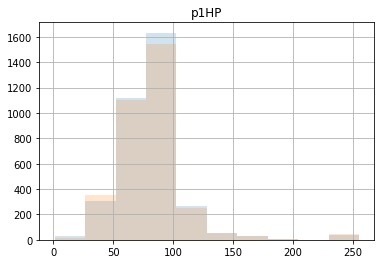

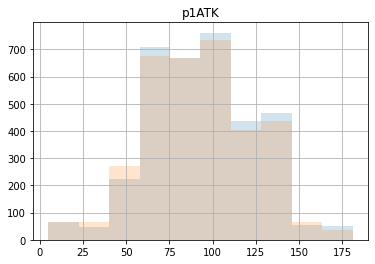

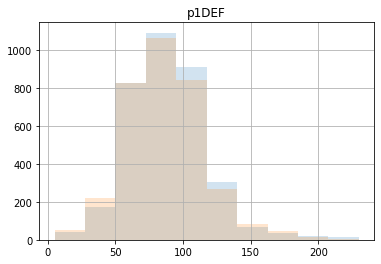

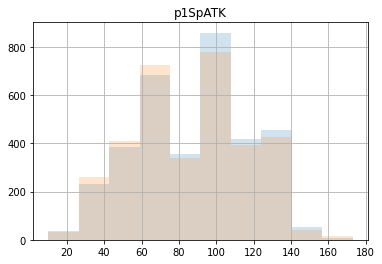

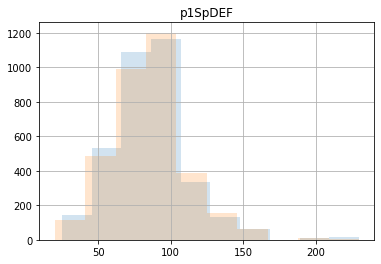

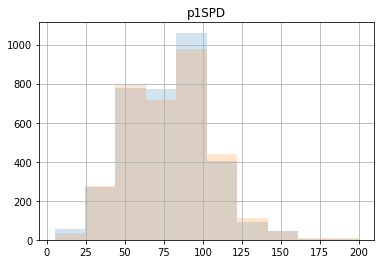

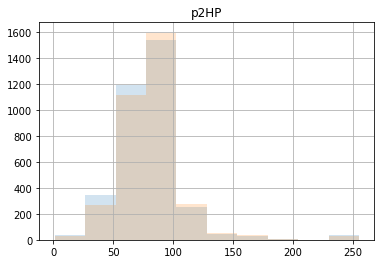

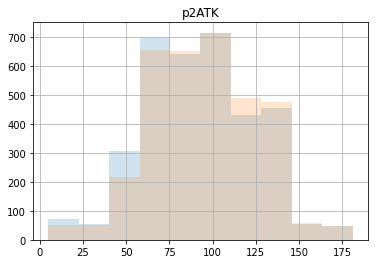

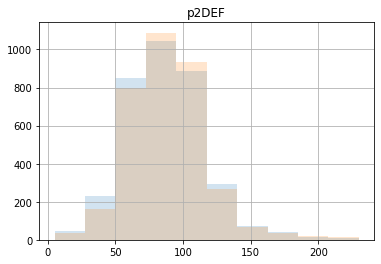

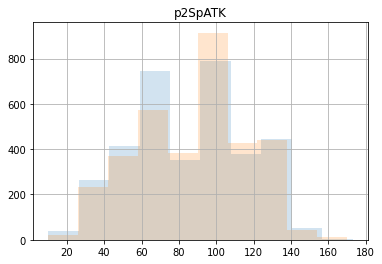

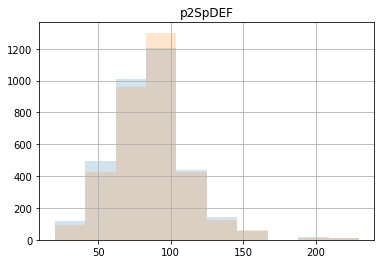

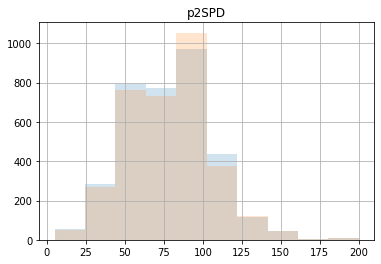

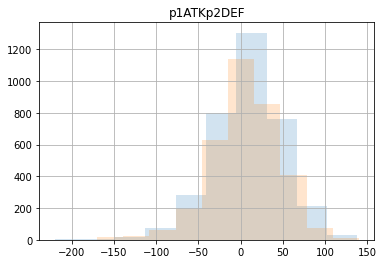

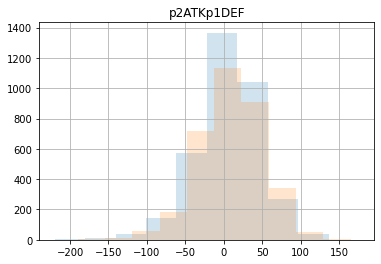

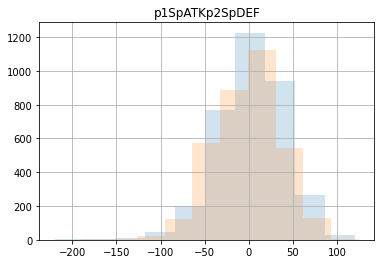

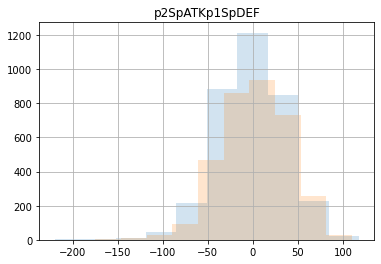

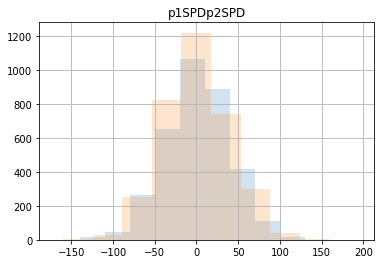

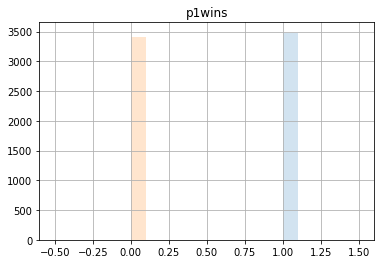

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

for col in df.columns: 
    df.loc[ df['p1wins'] == 1, col].hist(alpha=0.2)
    df.loc[ df['p1wins'] == 0, col].hist(alpha=0.2)
    plt.title(col)
    plt.show()

The histograms show the distributions of labelled data for each feature.  
Most of the case are overlapping so that it is hard to classify them by looking at each feature, suggesting there is no significant pattern for the model to identify and distinguish whether winning or losing.   
___

## Modelling 
Trying:  
- kNN  
- logistic regression  
- decision tree  

with hyperparameters optimasation and ROC & AUC evaluation, defined as 2 functions for simplification on codes 

## Hyperparameters Optimasation

In [17]:
from sklearn.model_selection import GridSearchCV

def GridSearch_train(learner, grid: dict, X_train, y_train, showAll: bool=False):
    '''
    learner: ML algorithm class \n
    grid: hyperparameters in dictionary with keywords \n
    X_train, y_train: training data \n
    showAll: boolean for showing all details in .cv_results_, default False (showing only combination of hyperparameters and mean_test_score, mean_train_score) \n
    returns results (mean_test_score, mean_train_score) for each combination of hyperparameters
    ''' 
    model = GridSearchCV(estimator=learner, param_grid=grid, return_train_score=True)
    model.fit(X_train, y_train)
    if showAll: 
        return pd.DataFrame( model.cv_results_ )
    return pd.DataFrame( model.cv_results_ )[['params', 'mean_test_score', 'mean_train_score']]

## ROC and AUC Evaluation

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

def showROC(y_train, y_test, y_pred_train_proba, y_pred_test_proba, title: str='unknown learner'): 
    '''
    y_train: training data (label) \n
    y_test: testing data (label) \n
    y_pred_train_proba: model predicting training data, in .predict_proba() \n
    y_pred_test_proba: model predicting test data, in .predict_proba() \n
    returns AUC and ROC plot of both \n
    only works with label_set = {0, 1} and 1 is True
    '''
    tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, y_pred_train_proba[:, 1])
    test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_pred_test_proba[:, 1])
    RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot(name=f'train_{title}: AUC={round(auc(tr_fpr, tr_tpr), 3)}')
    RocCurveDisplay(fpr=test_fpr, tpr=test_tpr).plot(name=f'test_{title}: AUC={round(auc(test_fpr, test_tpr), 3)}')
    pass

### kNN
1. naive kNN (all default hyperparameters)
2. with hyperparameters optimasation

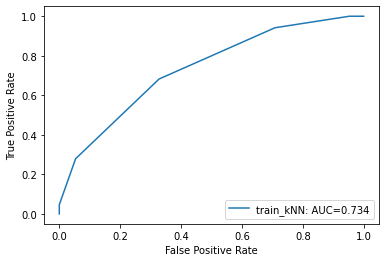

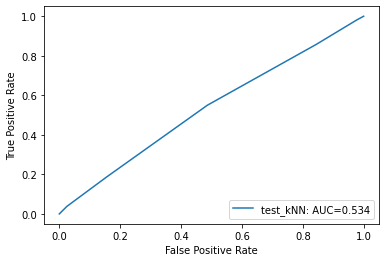

In [19]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(X_train_scaled, y_train)
y_pred_kNN = kNN.predict(X_test_scaled)
y_score_train_kNN = kNN.predict_proba(X_train_scaled)
y_score_test_kNN = kNN.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_kNN, y_pred_test_proba=y_score_test_kNN, title='kNN')

In [20]:
grid_kNN = {
    'n_neighbors': [1, 65, 501, 3501], 
    'weights': ['uniform', 'distance']
    }
GridSearch_train(learner=KNeighborsClassifier(n_jobs=-1), grid=grid_kNN, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'n_neighbors': 1, 'weights': 'uniform'}",0.461049,0.961447
1,"{'n_neighbors': 1, 'weights': 'distance'}",0.461049,0.961447
2,"{'n_neighbors': 65, 'weights': 'uniform'}",0.511774,0.558707
3,"{'n_neighbors': 65, 'weights': 'distance'}",0.471467,0.961447
4,"{'n_neighbors': 501, 'weights': 'uniform'}",0.519253,0.527683
5,"{'n_neighbors': 501, 'weights': 'distance'}",0.473962,0.961447
6,"{'n_neighbors': 3501, 'weights': 'uniform'}",0.500452,0.502661
7,"{'n_neighbors': 3501, 'weights': 'distance'}",0.475776,0.961447


kNN gave generally good results on training dataset but on testing dataset showed lower and consistent results, suggesting some kind of overfitting or memerisation issues.  
The first grid search showed better results at `n_neighbors` between 65 to 3501 and `weights` is uniform.  

In [21]:
grid_kNN = {
    'n_neighbors': [71, 101, 301, 501, 801, 1001],
    }
GridSearch_train(learner=KNeighborsClassifier(n_jobs=-1, weights='uniform'), grid=grid_kNN, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'n_neighbors': 71},0.515624,0.557348
1,{'n_neighbors': 101},0.511326,0.547837
2,{'n_neighbors': 301},0.511098,0.526608
3,{'n_neighbors': 501},0.519253,0.527683
4,{'n_neighbors': 801},0.508834,0.518682
5,{'n_neighbors': 1001},0.520382,0.522872


In [22]:
grid_kNN = {
    'n_neighbors': [1001, 1201, 1401, 1601, 1801],
    }
GridSearch_train(learner=KNeighborsClassifier(n_jobs=-1, weights='uniform'), grid=grid_kNN, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'n_neighbors': 1001},0.520382,0.522872
1,{'n_neighbors': 1201},0.509061,0.521060
2,{'n_neighbors': 1401},0.516304,0.522419
3,{'n_neighbors': 1601},0.516989,0.519079
4,{'n_neighbors': 1801},0.519025,0.514606


So, I believed kNN with the hyperparameters `n_neighbors=1001` and `weights='uniform'` tried its best to give both reliable results and the highest score. 

In [23]:
kNN_best = KNeighborsClassifier(n_jobs=-1, n_neighbors=1001, weights='uniform')

## LogisticRegression
1. naive LogisticRegression (all default hyperparameters)
2. with hyperparameters optimasation

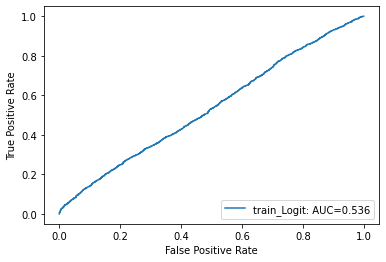

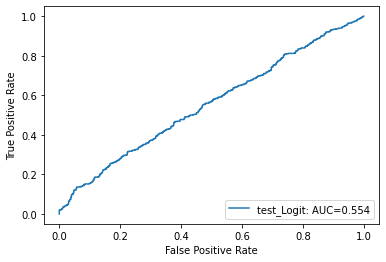

In [24]:
from sklearn.linear_model import LogisticRegression

Logit = LogisticRegression()
Logit.fit(X_train_scaled, y_train)
y_pred_Logit = Logit.predict(X_test_scaled)
y_score_train_Logit = Logit.predict_proba(X_train_scaled)
y_score_test_Logit = Logit.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Logit, y_pred_test_proba=y_score_test_Logit, title='Logit')

In [25]:
grid_Logit = {
    'l1_ratio': [0.25, 0.5, 0.75]
    }
GridSearch_train(learner=LogisticRegression(n_jobs=-1, penalty='elasticnet', solver='saga'), grid=grid_Logit, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'l1_ratio': 0.25},0.511776,0.518116
1,{'l1_ratio': 0.5},0.512682,0.518456
2,{'l1_ratio': 0.75},0.513134,0.518569


Logistic regression showed consistent but quite bad results.  
The first grid search showed better results may appear at high `l1_ratio`

In [26]:
grid_Logit = {
    'l1_ratio': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    }
GridSearch_train(learner=LogisticRegression(n_jobs=-1, penalty='elasticnet', solver='saga'), grid=grid_Logit, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'l1_ratio': 0.75},0.513134,0.518569
1,{'l1_ratio': 0.8},0.512908,0.518796
2,{'l1_ratio': 0.85},0.512908,0.518739
3,{'l1_ratio': 0.9},0.512908,0.518739
4,{'l1_ratio': 0.95},0.513134,0.518626
5,{'l1_ratio': 0.99},0.513587,0.518626


What if only L1 regularisation is used? With the `Inverse of regularization strength` `C`. 

In [27]:
grid_Logit = {
    'C': [0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 1.8]
    }
GridSearch_train(learner=LogisticRegression(n_jobs=-1, penalty='l1', solver='saga'), grid=grid_Logit, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'C': 0.2},0.512002,0.519758
1,{'C': 0.5},0.511322,0.518512
2,{'C': 0.8},0.512455,0.518682
3,{'C': 1.0},0.513587,0.518682
4,{'C': 1.2},0.512908,0.518796
5,{'C': 1.5},0.512682,0.518512
6,{'C': 1.8},0.512682,0.518626


Not much of a change.  
So, I believed Logistic regression with the hyperparameters `penalty='l1'`, `solver='saga'` and `C=1.0` (which is default for `C`) tried its best to give both reliable results and the highest score. 

In [28]:
Logit_best = LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')

## DecisionTree
1. naive DecisionTree (all default hyperparameters)
2. with hyperparameters optimasation

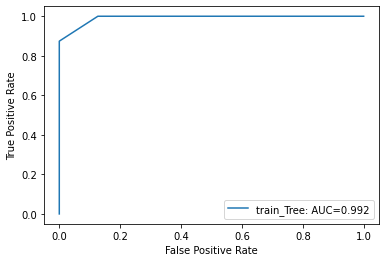

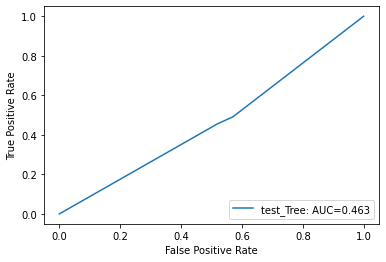

In [29]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier()
Tree.fit(X_train_scaled, y_train)
y_pred_Tree = Tree.predict(X_test_scaled)
y_score_train_Tree = Tree.predict_proba(X_train_scaled)
y_score_test_Tree = Tree.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Tree, y_pred_test_proba=y_score_test_Tree, title='Tree')

In [30]:
grid_Tree = {
    'max_depth': [2, 5, 10, 20],  
    'min_samples_leaf': [5, 25, 50, 100, 200, 500]
    }
GridSearch_train(learner=DecisionTreeClassifier(random_state=seed), grid=grid_Tree, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'min_samples_leaf': 5}",0.501356,0.534024
1,"{'max_depth': 2, 'min_samples_leaf': 25}",0.501356,0.534024
2,"{'max_depth': 2, 'min_samples_leaf': 50}",0.501356,0.534024
3,"{'max_depth': 2, 'min_samples_leaf': 100}",0.502261,0.532156
4,"{'max_depth': 2, 'min_samples_leaf': 200}",0.509736,0.533118
5,"{'max_depth': 2, 'min_samples_leaf': 500}",0.516304,0.530740
6,"{'max_depth': 5, 'min_samples_leaf': 5}",0.512229,0.571219
7,"{'max_depth': 5, 'min_samples_leaf': 25}",0.509738,0.570030
8,"{'max_depth': 5, 'min_samples_leaf': 50}",0.509513,0.570142
9,"{'max_depth': 5, 'min_samples_leaf': 100}",0.509286,0.563462


DecisionTree gave generally showed string overfitting or memerisation issues in naive training but disappeared while grid search.  
The first grid search showed better results at `max_depth=5` and `min_samples_leaf=200`.  
Further optimasation can be done but I don't think it will make a significant boost on testing score, ie. > 55%. 

In [31]:
Tree_best = DecisionTreeClassifier(random_state=seed, max_depth=5, min_samples_leaf=200)

## Second attempt on feature selection  
1. p-values suggested features 5 and 16 were unlikely to be generated randomly  
2. histograms showed features 12 to 16 were relatively less overlapping  

Here using only the best learners found from the grid search process above. 

In [32]:
# define a function for training and testing
def fitIt(learner, X_train, y_train, X_test, y_test, name: str): 
    model = learner
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score_train = model.predict_proba(X_train)
    y_score_test = model.predict_proba(X_test)

    showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train, y_pred_test_proba=y_score_test, title=name)

Trying only features 5 and 16

In [33]:
X_try_train = X_train_scaled[:, [5, 16]]
X_try_test = X_test_scaled[:, [5, 16]]

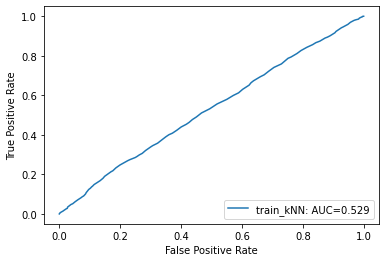

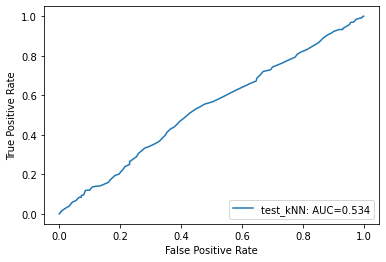

In [34]:
fitIt(learner=kNN_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='kNN')

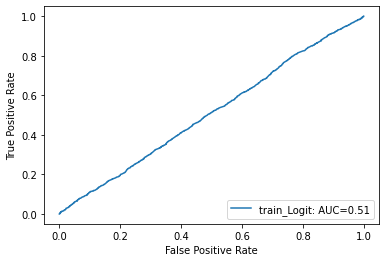

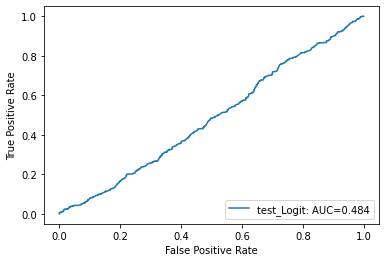

In [35]:
fitIt(learner=Logit_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='Logit')

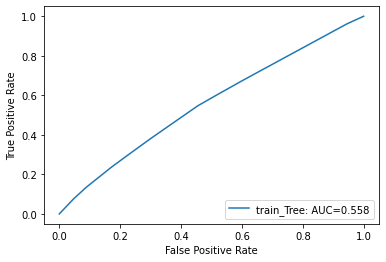

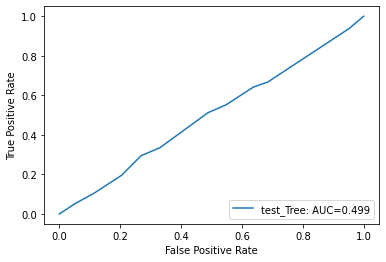

In [36]:
fitIt(learner=Tree_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='Tree')

Next trying only features 12 to 16

In [37]:
X_try_train = X_train_scaled[:, 12:16+1]
X_try_test = X_test_scaled[:, 12:16+1]

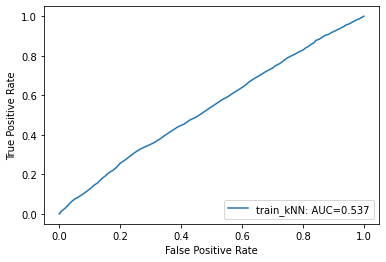

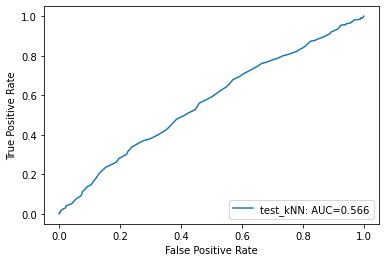

In [38]:
fitIt(learner=kNN_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='kNN')

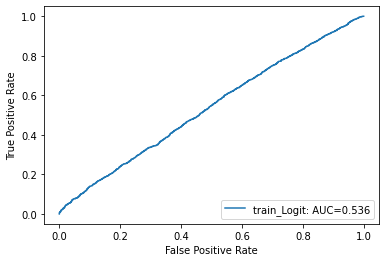

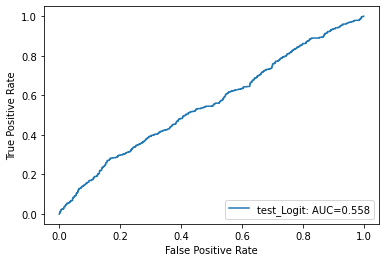

In [39]:
fitIt(learner=Logit_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='Logit')

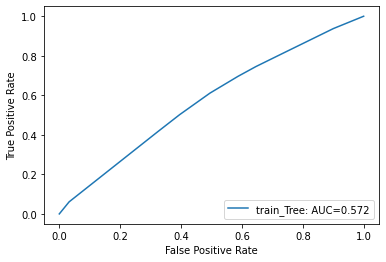

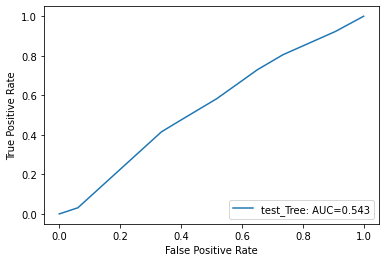

In [40]:
fitIt(learner=Tree_best, X_train=X_try_train, y_train=y_train, X_test=X_try_test, y_test=y_test, name='Tree')

Including only Features 12 to 16 appeared to give a slightly improved results on testing.  
However, only features 5 and 16 is making the model worse, some even had AUC < 0.5. 
Using all features is basically the same as using only features 12 to 16. 
___

## $f_m$ Optimisation
This is a measure of how good a particular threshold value is:   
$$ 
\begin{align}
    f_m &= \text{TPR} - m \times \text{FPR} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{\text{cost of negative}}{\text{cost of positive}} \\
    \text{threshold}_{best} &= \mathrm{argmax}\ f_m
\end{align}
$$
Sometimes:  
$$
\begin{align}
    \text{cost of negative} &= \text{cost of False positive} - \text{cost of True negative} \\
    \text{cost of positive} &= \text{cost of False negative} - \text{cost of True positive} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{C_{FP}-C_{TN}}{C_{FN}-C_{TP}}
\end{align}
$$
$\text{cost of negative}$ and $\text{cost of positive}$ are pre-determined values and usually we guess them based on the consequences for getting negative or positive results.  
So, within a set of values for threshold, the higher $f_m$ value, the better threshold.  

The cost of negative is decided to be twice as much as cost of positive, due to <a href="https://en.wikipedia.org/wiki/Loss_aversion">Loss aversion by Amos Tversky and Daniel Kahneman</a>. 

In [41]:
prevalence_test = np.sum( y_test==1 ) / len(y_test) # prevalence of testing data
prevalence_test 

0.5253623188405797

In [42]:
def fmOptimisation(prevalence: float, threshold: np.ndarray, FPR: np.ndarray, TPR: np.ndarray, name: str='unknown learner', cost_negative: float=2 , cost_positive:float=1): 
    m = (1-prevalence)/prevalence * cost_negative/cost_positive
    fm = TPR - m*FPR
    best_threshold = threshold[ np.argmax(fm) ]
    best_fpr = FPR[ np.argmax(fm) ]
    best_tpr = TPR[ np.argmax(fm) ]
    print(f'{name}-best threshold: {best_threshold}\n{name}-best FPR: {best_fpr}\n{name}-best TPR: {best_tpr}')
    return best_threshold, best_fpr, best_tpr

In [43]:
def validate(learner, X_train, y_train, X_val, y_val, name: str): 
    model = learner.fit(X_train, y_train)
    y_val_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)
    fpr, tpr, threshold = roc_curve(y_val, y_val_proba[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(name=f'train_{name}: AUC={round(auc(fpr, tpr), 3)}')
    return fpr, tpr, threshold, y_pred

kNN-best threshold: 0.5364635364635365
kNN-best FPR: 0.01717557251908397
kNN-best TPR: 0.04655172413793104


(0.5364635364635365, 0.01717557251908397, 0.04655172413793104)

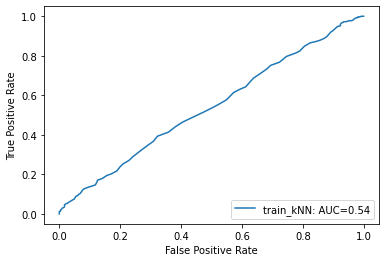

In [44]:
kNN_best_info = validate(learner=kNN_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='kNN')

fmOptimisation(prevalence=prevalence_test, threshold=kNN_best_info[2], FPR=kNN_best_info[0], TPR=kNN_best_info[1], name='kNN', cost_negative=2 , cost_positive=1)

Logit-best threshold: 0.5594572669648934
Logit-best FPR: 0.04770992366412214
Logit-best TPR: 0.11896551724137931


(0.5594572669648934, 0.04770992366412214, 0.11896551724137931)

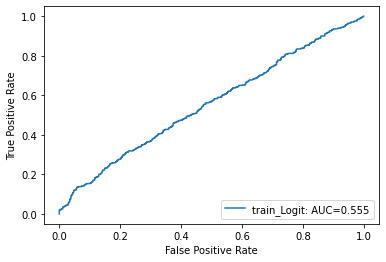

In [45]:
Logit_best_info = validate(learner=Logit_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='Logit')

fmOptimisation(prevalence=prevalence_test, threshold=Logit_best_info[2], FPR=Logit_best_info[0], TPR=Logit_best_info[1], name='Logit', cost_negative=2 , cost_positive=1)

Tree-best threshold: 0.6561085972850679
Tree-best FPR: 0.03625954198473282
Tree-best TPR: 0.06724137931034482


(0.6561085972850679, 0.03625954198473282, 0.06724137931034482)

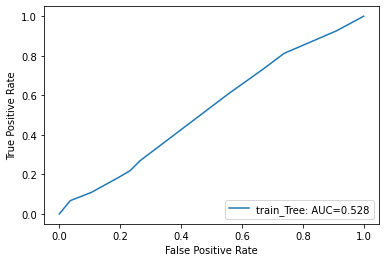

In [46]:
Tree_best_info = validate(learner=Tree_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='Tree')

fmOptimisation(prevalence=prevalence_test, threshold=Tree_best_info[2], FPR=Tree_best_info[0], TPR=Tree_best_info[1], name='Tree', cost_negative=2 , cost_positive=1)

With `cost_negative=2` and `cost_positive=1`, FPR reduced along with TPR. This means although we can lower the rate of getting false positive, we get much more less true positives too. As the model predicts less positives. This indicates a high FNR. 

Those two cost values may need changes.  
- Eg. Setting `cost_negative=1.4`

### kNN
cost_negative=1.218

kNN-best threshold: 0.5034965034965035
kNN-best FPR: 0.32251908396946566
kNN-best TPR: 0.3931034482758621


(0.5034965034965035, 0.32251908396946566, 0.3931034482758621)

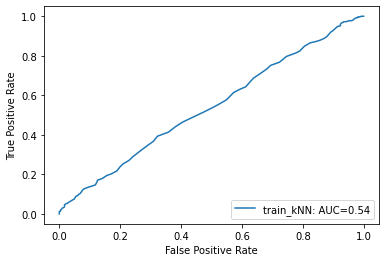

In [47]:
kNN_best_info = validate(learner=kNN_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='kNN')

fmOptimisation(prevalence=prevalence_test, threshold=kNN_best_info[2], FPR=kNN_best_info[0], TPR=kNN_best_info[1], name='kNN', cost_negative=1.218, cost_positive=1)

kNN-best threshold: 0.5214785214785215
kNN-best FPR: 0.07824427480916031
kNN-best TPR: 0.12413793103448276


(0.5214785214785215, 0.07824427480916031, 0.12413793103448276)

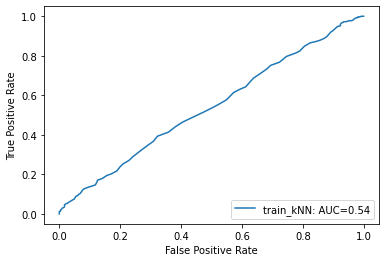

In [48]:
kNN_best_info = validate(learner=kNN_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='kNN')

fmOptimisation(prevalence=prevalence_test, threshold=kNN_best_info[2], FPR=kNN_best_info[0], TPR=kNN_best_info[1], name='kNN', cost_negative=1.219, cost_positive=1)

### Logistic regression
cost_negative=1.4

Logit-best threshold: 0.5558383960723966
Logit-best FPR: 0.05725190839694656
Logit-best TPR: 0.13448275862068965


(0.5558383960723966, 0.05725190839694656, 0.13448275862068965)

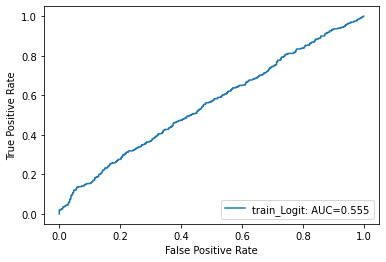

In [49]:
Logit_best_info = validate(learner=Logit_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='Logit')

fmOptimisation(prevalence=prevalence_test, threshold=Logit_best_info[2], FPR=Logit_best_info[0], TPR=Logit_best_info[1], name='Logit', cost_negative=1.4, cost_positive=1)

### Decision tree
cost_negative=1.17391

Tree-best threshold: 0.44299674267100975
Tree-best FPR: 0.7385496183206107
Tree-best TPR: 0.8120689655172414


(0.44299674267100975, 0.7385496183206107, 0.8120689655172414)

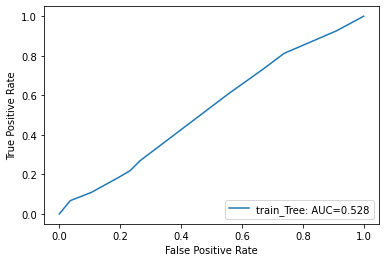

In [50]:
Tree_best_info = validate(learner=Tree_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='Tree')

fmOptimisation(prevalence=prevalence_test, threshold=Tree_best_info[2], FPR=Tree_best_info[0], TPR=Tree_best_info[1], name='Tree', cost_negative=1.17391, cost_positive=1)

Tree-best threshold: 0.6561085972850679
Tree-best FPR: 0.03625954198473282
Tree-best TPR: 0.06724137931034482


(0.6561085972850679, 0.03625954198473282, 0.06724137931034482)

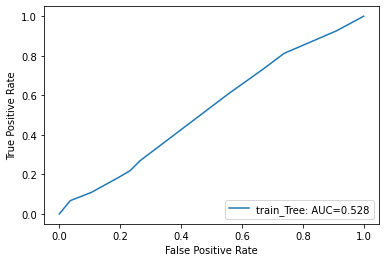

In [51]:
Tree_best_info = validate(learner=Tree_best, X_train=X_train_scaled, y_train=y_train, X_val=X_test_scaled, y_val=y_test, name='Tree')

fmOptimisation(prevalence=prevalence_test, threshold=Tree_best_info[2], FPR=Tree_best_info[0], TPR=Tree_best_info[1], name='Tree', cost_negative=1.17392, cost_positive=1)

After tuning the values of costs, I realised the FPR and TPR changes rapidly and dramatically with some crictical values, especially for Decision tree.  
This may suggest $f_m$ Optimisation in an unsignificant model is hard, all depends on which error, FP or FN, is more exceptable or favorable.   

## Validation

In [52]:
prevalence_val = np.sum( y_val==1 ) / len(y_val)
# if whole dataset, then ` prevalence = np.sum( df['p1wins'].to_numpy()==1 ) / (len(df['p1wins'].to_numpy())) `
prevalence_val

0.4985507246376812

### kNN and its confusion matrix

kNN-best threshold: 0.5474525474525475
kNN-best FPR: 0.004335260115606936
kNN-best TPR: 0.01308139534883721


(0.5474525474525475, 0.004335260115606936, 0.01308139534883721)

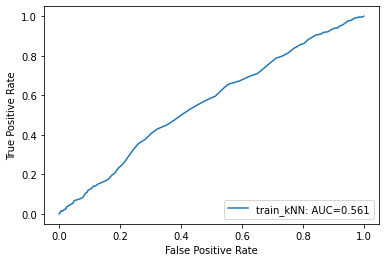

In [53]:
kNN_best_info = validate(learner=kNN_best, X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val, name='kNN')

fmOptimisation(prevalence=prevalence_test, threshold=kNN_best_info[2], FPR=kNN_best_info[0], TPR=kNN_best_info[1], name='kNN', cost_negative=2, cost_positive=1)

### Logistic regression and its confusion matrix

Logit-best threshold: 0.5771819448620491
Logit-best FPR: 0.024566473988439308
Logit-best TPR: 0.046511627906976744


(0.5771819448620491, 0.024566473988439308, 0.046511627906976744)

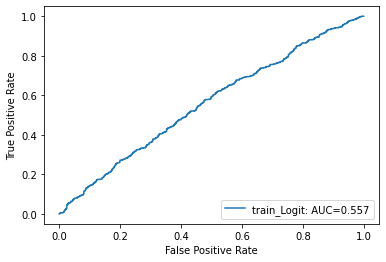

In [54]:
Logit_best_info = validate(learner=Logit_best, X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val, name='Logit')

fmOptimisation(prevalence=prevalence_test, threshold=Logit_best_info[2], FPR=Logit_best_info[0], TPR=Logit_best_info[1], name='Logit', cost_negative=2, cost_positive=1)

### Decision tree and its confusion matrix

Tree-best threshold: 1.6561085972850678
Tree-best FPR: 0.0
Tree-best TPR: 0.0


(1.6561085972850678, 0.0, 0.0)

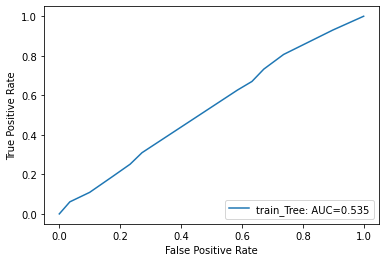

In [55]:
Tree_best_info = validate(learner=Tree_best, X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val, name='Tree')

fmOptimisation(prevalence=prevalence_test, threshold=Tree_best_info[2], FPR=Tree_best_info[0], TPR=Tree_best_info[1], name='Tree', cost_negative=2, cost_positive=1)

Even within the validation dataset, the $f_m$ Optimisation with `cost_negative=2` caused the model to predict mostly False and all False in Decision tree model (due to the threshold > 1).  
If we aim to getting better looking results on TPR and FPR, we have to tune the costs but then this action violates the main idea of $f_m$ Optimisation. Therefore, I would say $f_m$ Optimisation is not applicable in these models. 

# Conclusion

1. Models  
It seems like Logistic regression model gives the most moderate results. However, each model gives an AUC of around 0.5, making them perform roughly the same as random guessing. The reason could be due to lack of data, data memorisation, or just simply Pokémon is too good on having a balanced game such that the outcome of a Pokémon battle doesn't relate too much with Pokémons' base stats. 

2. $f_m$ Optimisation  
Getting an Optimised threshold values is not helpful in these models, since the predictions are too sensitive and extreme to different thresholds. Just a slight change on the costs can results in completely opposite predictions.   

3. Future works  
This notebook already shows Pokémon battle outcome is not solely related to Pokémons' base stats, but also many other factors.  
Things to do can be:  
    - analyse even more attributes of each Pokémon, such as types, weaknesses, abilities or natures  
    - investigate what other factors hidden in each battle, such as number of turns, items carried, or what moves are played  
    - give up and move on, there is nothing much I can do